In [1]:
import numpy as N
import pandas
import tqdm
import matplotlib.pyplot as pyplot
import seaborn

seaborn.set_style('whitegrid')

import tqdm
import torch as T
import torch.distributions as TD
import torch.distributions.constraints as TDC
import torch.nn as TN
import torch.nn.functional as TNF
import pyro as P
import pyro.infer as PI
import pyro.optim as PO
import pyro.distributions as PD
import pyro.nn as PN
import pyro.poutine as PP

P.set_rng_seed(0)

In [2]:
import sys
sys.path.append('../..')
import igg
import model
import guide

In [3]:
# Data Generation
nData = 256
data = [model.generate() for _ in range(nData)]

elbo = PI.Trace_ELBO()

100%|██████████| 400/400 [04:35<00:00,  1.45it/s]


<AxesSubplot:xlabel='step', ylabel='loss'>

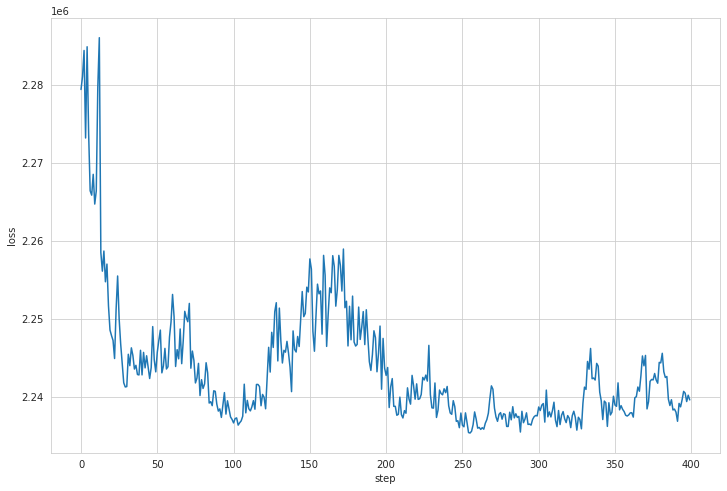

In [4]:
P.clear_param_store()
svi = PI.SVI(model=model.model,
            guide=guide.model,
            optim=PO.Adam({"lr": 0.001, "betas": (0.95,0.999)}),
            loss=elbo
            )
hist = pandas.DataFrame(columns=["step", "loss"])
for step in tqdm.trange(400):
    loss = sum([svi.step(*d) for d in data])
    hist = hist.append({
        "step": step,
        "loss": loss,
    }, ignore_index=True)

fig, ax = pyplot.subplots(figsize=(12,8))
seaborn.lineplot(x="step", y="loss", data=hist, ax=ax)

# Compare

In [5]:
# an unconditioned version of the model

def model_uncond():
    r = model.model_core(0.0, i=0)
    P.sample("r", PD.Normal(0.0,0.01))

tracedModelUncond = PP.trace(model_uncond)
tracedGuide = PP.trace(guide.model)

def trace_model_uncond():
    trace = tracedModelUncond.get_trace()
    obs = trace.nodes['r']['value']
    maxi = 0
    while f'q_{maxi}' in trace.nodes:
        maxi += 1
    return maxi, obs

def trace_guide(obs):
    trace = tracedGuide.get_trace(obs)
    maxi = 0
    while f'q_{maxi}' in trace.nodes:
        maxi += 1
    return maxi
def single_sample():
    iModel,obs = trace_model_uncond()
    iGuide = trace_guide(obs)
    iModel = min(int(iModel), 7)
    iGuide = min(int(iGuide), 7)
    return iModel, iGuide
def sample_model_guide(nSamples):
    samples = [single_sample() for _ in range(nSamples)]
    import collections
    occ = collections.Counter(samples)
    
    mat = N.zeros((8,8))
    for k,v in occ.items():
        mat[k] = v
    result = pandas.DataFrame(mat)
    result.columns.name = 'iGuide'
    result.index.name = 'iModel'
    
    # Calculate the indicators
    yTrue, yPred = zip(*samples)
    import sklearn.metrics as SM
    print(SM.classification_report(yTrue, yPred))
    return result


In [6]:
data = sample_model_guide(1000)
data

              precision    recall  f1-score   support

           1       0.20      0.85      0.32       205
           2       0.16      0.10      0.12       170
           3       0.06      0.01      0.01       122
           4       0.00      0.00      0.00       113
           5       0.00      0.00      0.00        64
           6       0.00      0.00      0.00        78
           7       0.00      0.00      0.00       248

    accuracy                           0.19      1000
   macro avg       0.06      0.14      0.07      1000
weighted avg       0.07      0.19      0.09      1000



/usr/local/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


iGuide    0      1     2    3    4    5    6    7
iModel                                           
0       0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0
1       0.0  175.0  26.0  4.0  0.0  0.0  0.0  0.0
2       0.0  150.0  17.0  3.0  0.0  0.0  0.0  0.0
3       0.0  105.0  16.0  1.0  0.0  0.0  0.0  0.0
4       0.0   97.0  15.0  1.0  0.0  0.0  0.0  0.0
5       0.0   57.0   6.0  1.0  0.0  0.0  0.0  0.0
6       0.0   66.0  10.0  2.0  0.0  0.0  0.0  0.0
7       0.0  223.0  19.0  6.0  0.0  0.0  0.0  0.0

<AxesSubplot:xlabel='iGuide', ylabel='iModel'>

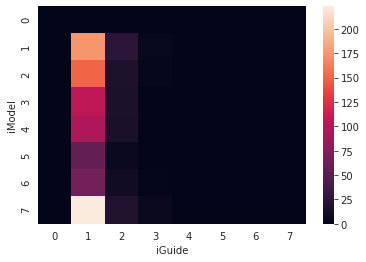

In [7]:
seaborn.heatmap(data)